Text(0.5, 0.98, '未知数の事前分布')

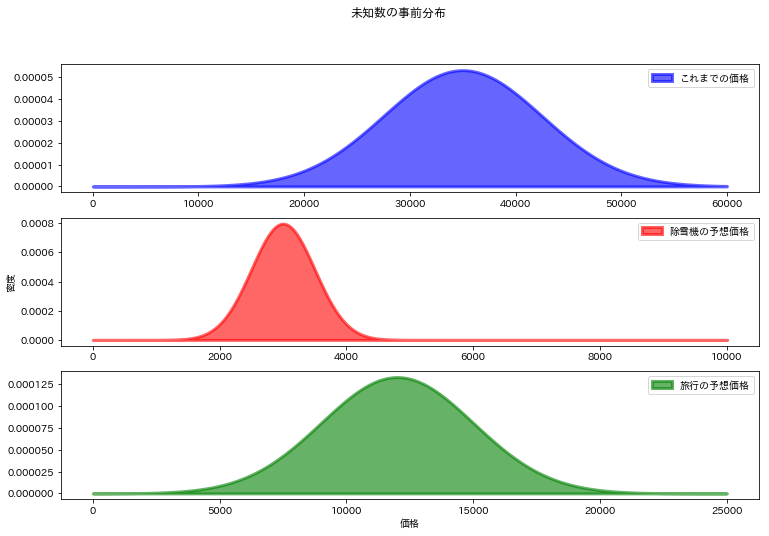

In [22]:
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

figsize(12.5, 8)

norm_pdf = stats.norm.pdf

plt.subplot(311)
x = np.linspace(0, 60000, 200) 
plt.fill_between(x, 0, norm_pdf(x, 35000, 7500), color="blue", lw=3, alpha=0.6, label="これまでの価格")
plt.legend()

plt.subplot(312)
x = np.linspace(0, 10000, 200)
plt.fill_between(x, 0, norm_pdf(x, 3000, 500), color="red", lw=3, alpha=0.6, label="除雪機の予想価格")
plt.ylabel("密度")
plt.legend()

plt.subplot(313)
x = np.linspace(0, 25000, 200)
sp3 = plt.fill_between(x, 0, norm_pdf(x, 12000, 3000), color="green", lw=3, alpha=0.6, label="旅行の予想価格")
plt.legend()
plt.xlabel("価格")
plt.suptitle("未知数の事前分布")

In [23]:
import pymc as pm

data_mu = [3e3, 12e3]
data_std = [5e2, 3e3]
mu_prior = 35e3
std_prior = 75e2

true_price  = pm.Normal("true_price", mu_prior, 1.0 / std_prior ** 2)
prize_1 = pm.Normal("first_prize", data_mu[0], 1.0 / data_std[0] ** 2)
prize_2 = pm.Normal("second_prize", data_mu[1], 1.0 / data_std[1] ** 2)

price_estimate = prize_1 + prize_2

@pm.potential
def error(true_price = true_price, price_estimate=price_estimate):
    return pm.normal_like(true_price, price_estimate, 1/(3e3)**2)

mcmc = pm.MCMC([true_price, prize_1, prize_2, price_estimate, error])
mcmc.sample(50000, 10000)

price_trace = mcmc.trace("true_price")[:]    


 [-----------------100%-----------------] 50000 of 50000 complete in 4.9 sec

/Users/yukisunami/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


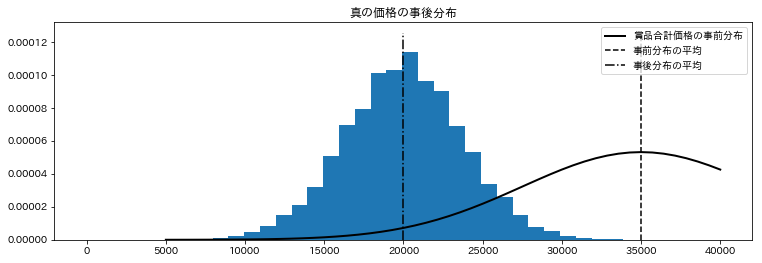

In [24]:
figsize(12.5, 4)
import scipy.stats as stats

# 事前分布のプロット
x = np.linspace(5000, 40000)
plt.plot(x, stats.norm.pdf(x, 35000, 7500), c="k", lw=2, label="賞品合計価格の事前分布")

# MCMCから得られたサンプルで表した事後分布のプロット
_hist = plt.hist(price_trace, bins=35, normed=True, histtype="stepfilled")
plt.vlines(mu_prior, 0, 1.1 * np.max(_hist[0]), linestyles="--", label="事前分布の平均")

plt.vlines(price_trace.mean(), 0, 1.1 * np.max(_hist[0]), linestyles="-.", label = "事後分布の平均")

plt.title("真の価格の事後分布")
plt.legend()

In [25]:
a = np.zeros(10)
b = np.concatenate([np.zeros(5),np.arange(5)], axis=0)
c = np.ones(10)
bools = b < c
a[bools] = 1000
print(a ,b, c, bools)

[1000. 1000. 1000. 1000. 1000. 1000.    0.    0.    0.    0.] [0. 0. 0. 0. 0. 0. 1. 2. 3. 4.] [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] [ True  True  True  True  True  True False False False False]


/Users/yukisunami/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


(5000, 30000)

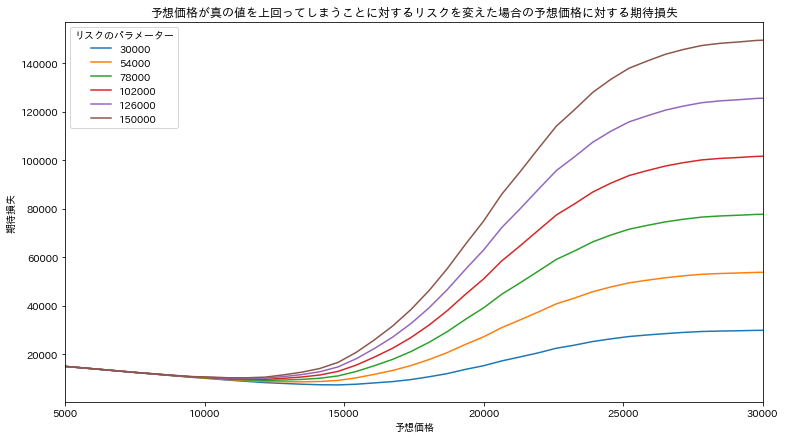

In [26]:
figsize(12.5, 7)

def showdown_loss(guess, true_price, risk=80000):
    loss = np.zeros_like(true_price)
    ix = true_price < guess
    loss[~ix] = np.abs(guess - true_price[~ix]) # 予測が下回ったインデックスでは誤差をlossにする
    close_mask = [abs(true_price - guess) <= 250] # 予測が下回ったもののうち誤差が250以内の場合
    loss[close_mask] = -2 * true_price[close_mask] # 賞品の2倍を負のlossとする
    loss[ix] = risk # 予測が上回ってしまったインデックスではrisk値をlossとする
    return loss

guesses = np.linspace(5000, 50000, 70)
risks = np.linspace(30000, 150000, 6)
expected_loss = lambda guess, risk: \
    showdown_loss(guess, price_trace, risk).mean()

for _p in risks:
    results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, results, label="%d" % _p)
    
plt.title("予想価格が真の値を上回ってしまうことに対するリスクを変えた場合の予想価格に対する期待損失")
plt.legend(title="リスクのパラメーター")
plt.xlabel("予想価格")
plt.ylabel("期待損失")
plt.xlim(5000, 30000)

/Users/yukisunami/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


リスク: 30000.0 での最小値: [14440.00178576]
リスク: 54000.0 での最小値: [13552.58077383]
リスク: 78000.0 での最小値: [12141.71862602]
リスク: 102000.0 での最小値: [11643.81551743]
リスク: 126000.0 での最小値: [11643.81551743]
リスク: 150000.0 での最小値: [11039.04032707]


(-1000, 80000)

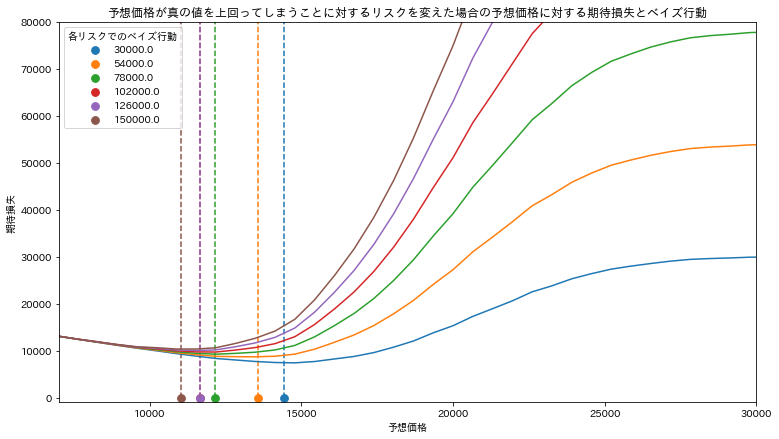

In [31]:
import scipy.optimize as sop

ax = plt.subplot(111)

for _p in risks:
    _color = next(ax._get_lines.prop_cycler)
    _min_results = sop.fmin(expected_loss, 15000, args=(_p,), disp=False)
    _results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, _results, color=_color['color'])
    plt.scatter(_min_results, 0, s=60, color=_color['color'], label=_p)
    plt.vlines(_min_results, 0, 120000, color=_color['color'], linestyles="--" )
    print("リスク: {} での最小値: {}".format(_p, _min_results))
    
plt.title("予想価格が真の値を上回ってしまうことに対するリスクを変えた場合の予想価格に対する期待損失とベイズ行動")
plt.legend(title="各リスクでのベイズ行動")
plt.xlabel("予想価格")
plt.ylabel("期待損失")
plt.xlim(7000, 30000)
plt.ylim(-1000, 80000)
    

In [29]:
_results

[15024.873820762237,
 14395.32094705139,
 13747.110267468834,
 13095.164615294918,
 12450.947527894545,
 11884.288097117042,
 11303.123572109876,
 10809.627276768813,
 10600.53705714691,
 10321.46203575465,
 10320.964774220403,
 10587.371151445768,
 11510.592886882878,
 12605.130836298584,
 14144.074142969183,
 16646.690388332827,
 20790.992356507028,
 25936.624561965054,
 31646.108118899487,
 38380.6373823444,
 46232.080139693295,
 55251.218269059194,
 65292.135383927896,
 74913.89806737196,
 85993.99022333525,
 95185.45471236014,
 104718.74405771629,
 114058.58665774007,
 120847.59827284103,
 127974.75797162185,
 133398.66353752714,
 137957.9237711012,
 140936.66011778364,
 143709.32748119647,
 145700.74986357547,
 147317.3379454982,
 148209.61336614593,
 148761.00499454624,
 149402.1176129579,
 149656.06559491248,
 149811.74892496323,
 149891.28613281652,
 149962.71378775,
 149992.57424951767,
 149992.54164082202,
 149996.26316300302,
 150000.0,
 150000.0,
 150000.0,
 150000.0,
 150

ダークマターの観測

In [32]:
from os import makedirs
makedirs("data/Train_Skies/Train_Skies", exist_ok=True)

from urllib.request import urlretrieve
urlretrieve("https://git.io/vXLqk", "data/Train_Skies/Training_Sky3.csv")
urlretrieve("https://git.io/vXLqU", "draw_sky2.py")


('draw_sky2.py', <http.client.HTTPMessage at 0x1a1b4daf98>)

Data on galaxies in sky 3
位置x, y  楕円率 e_1, e_2
[[ 1.62690e+02  1.60006e+03  1.14664e-01 -1.90326e-01]
 [ 2.27228e+03  5.40040e+02  6.23555e-01  2.14979e-01]
 [ 3.55364e+03  2.69771e+03  2.83527e-01 -3.01870e-01]]


Text(0.5, 1.0, '天空番号3での銀河の楕円')

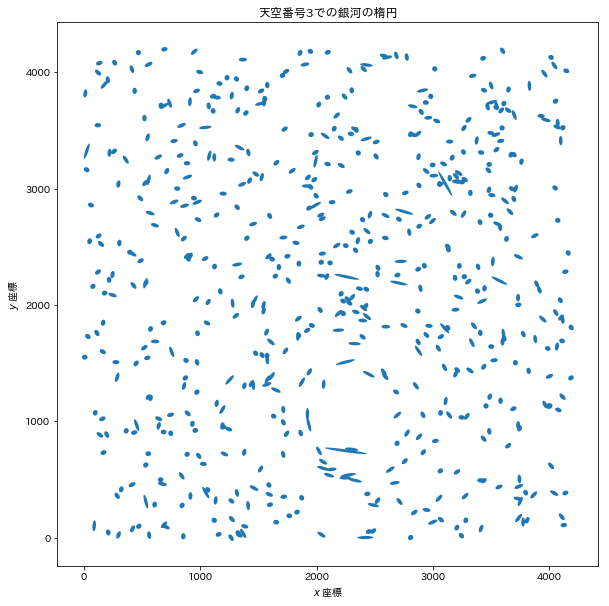

In [34]:
from draw_sky2 import draw_sky

n_sky = 3 # 天空ファイル番号
data = np.genfromtxt("data/Train_Skies/Training_Sky%d.csv" % n_sky, 
                     dtype=None, skip_header=1, delimiter=",", usecols=[1,2,3,4])
print("Data on galaxies in sky %d" % n_sky)
print("位置x, y  楕円率 e_1, e_2")
print(data[:3])

fig = draw_sky(data)
plt.xlabel("$x$ 座標")
plt.ylabel("$y$ 座標")
plt.title("天空番号3での銀河の楕円")

In [40]:
import pymc as pm

def euclidean_distance(x, y):
    return np.sqrt(((x - y)**2).sum(axis=1))

def f_distance(gxy_pos, halo_pos, c):
    # pos の 型はnumpy2Darray
    return np.maximum(euclidean_distance(gxy_pos, halo_pos), c)[:, None]

def tangential_distance(glxy_position, halo_position):
    # pos の 型はnumpy2Darray
    delta = glxy_position - halo_position
    t = (2 * np.arctan(delta[:, 1] / delta[:, 0]))[:, None]
    return np.concatenate([-np.cos(t), -np.sin(t)], axis=1)

# ハローの質量を設定
mass_large = pm.Uniform("mass_large", 40, 180, trace=False)

# ハローの事前分布は２次元一様分布とする
halo_position = pm.Uniform("halo_position", 0, 4200, size=(1, 2))

@pm.deterministic
def mean(mass=mass_large, h_pos=halo_position, glx_pos=data[:, :2]): #data[:, :2] = glx(x, y)
    return mass / f_distance(glx_pos, h_pos, 240) * tangential_distance(glx_pos, h_pos)

ellpty = pm.Normal("ellpticity", mean, 1. / 0.05, observed=True, value=data[:, 2:]) #data[:. 2:] = glx(e1,e2)

model = pm.Model([ellpty, mean, halo_position, mass_large])
map_ = pm.MAP(model)
map_.fit() # MCMCの前にMAPのfitを呼ぶ
mcmc = pm.MCMC(model)
mcmc.sample(200000, 140000, 3)

 [-----------------100%-----------------] 200000 of 200000 complete in 58.1 sec

Text(0.5, 1.0, '天空番号3でのハローの事後分布')

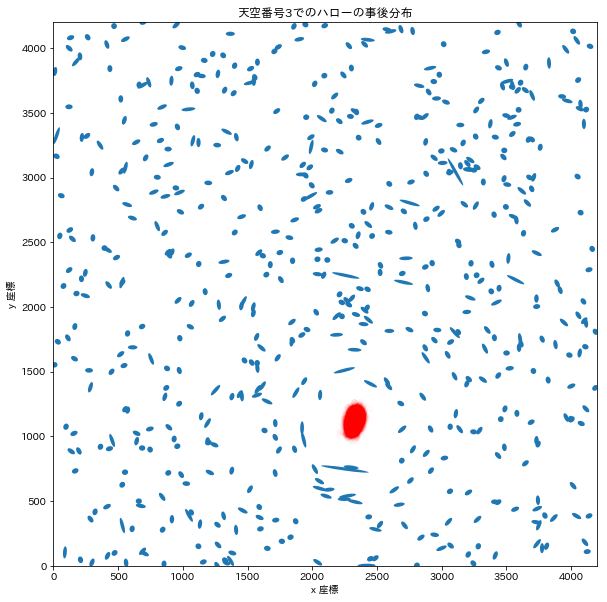

In [41]:
fig = draw_sky(data)

t = mcmc.trace("halo_position")[:].reshape(20000, 2)
plt.scatter(t[:, 0], t[:, 1], alpha=0.015, c="r")

plt.xlim(0, 4200)
plt.ylim(0, 4200)
plt.xlabel("x 座標")
plt.ylabel("y 座標")
plt.title("天空番号%dでのハローの事後分布" % n_sky)

In [46]:
urlretrieve("https://git.io/vXLm6", "data/Training_halos.csv")
halo_data = np.genfromtxt("data/Training_halos.csv", delimiter=",", skip_header=1, usecols={1,2,3,4,5,6,7,8,9})
print(halo_data[n_sky - 1])

[1.00000e+00 2.31578e+03 1.08195e+03 2.31578e+03 1.08195e+03 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00]


True halo location: 1408.61 1685.86


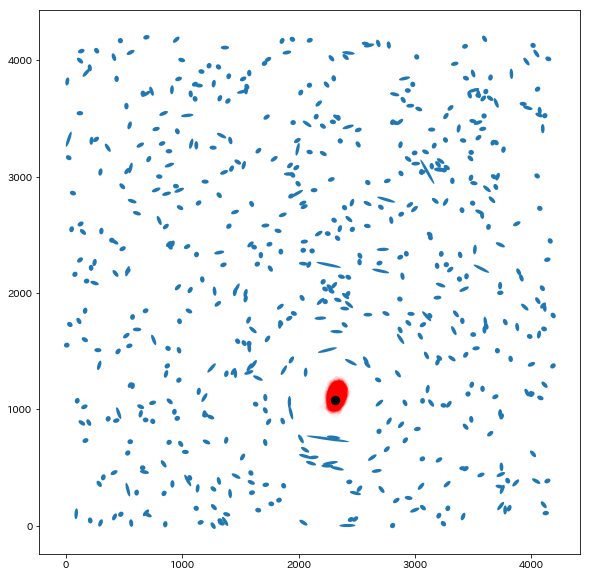

In [50]:
fig = draw_sky(data)

plt.scatter(t[:, 0], t[:, 1], alpha=0.015, c="r")
plt.scatter(halo_data[n_sky - 1][3], halo_data[n_sky - 1][4], label="true halo position",c="k", s=70)

print("True halo location:", halo_data[n_sky][3], halo_data[n_sky][4])

In [51]:
mean_posterior = t.mean(axis=0).reshape(1, 2)
print(mean_posterior)

[[2323.98660689 1124.2058793 ]]


In [52]:
# DarkWorldsMetric.py の ダウンロード
urlretrieve("https://git.io/vXLmx", "DarkWorldsMetric.py")

('DarkWorldsMetric.py', <http.client.HTTPMessage at 0x1a291c4358>)

In [56]:
from DarkWorldsMetric import main_score

_halo_data =  halo_data[n_sky - 1]

nhalo_all = _halo_data[0].reshape(1, 1)
x_ref_all = _halo_data[1].reshape(1, 1)
y_ref_all = _halo_data[2].reshape(1, 1)
x_true_all = _halo_data[3].reshape(1, 1)
y_true_all = _halo_data[4].reshape(1, 1)
sky_prediction = mean_posterior

print("平均を使う")
main_score(nhalo_all, x_true_all, y_true_all, x_ref_all, y_ref_all, sky_prediction)

print()

# 比較のために、ランダムな推論の場合のスコアを求める
random_guess = np.random.randint(0, 4200, size=(1, 2))
print("ランダムな位置を使う:", random_guess)
main_score(nhalo_all, x_true_all, y_true_all, x_ref_all, y_ref_all, random_guess)

平均を使う
Your average distance in pixels you are away from the true halo is 43.04541476172762
Your average angular vector is 0.9999999999999999
Your score for the training data is 1.0430454147617274

ランダムな位置を使う: [[3392 2318]]
Your average distance in pixels you are away from the true halo is 1638.923149784638
Your average angular vector is 1.0
Your score for the training data is 2.638923149784638


2.638923149784638

In [57]:
urlretrieve("https://git.io/vXqk4", "data/Train_Skies/Training_Sky215.csv")

('data/Train_Skies/Training_Sky215.csv',
 <http.client.HTTPMessage at 0x1a29367128>)

In [66]:
def halo_posteriors(n_halos_in_sky, galaxy_data, samples=5e5, burn_in=34e4, thin=4):
    # ハローの質量を設定
    mass_large = pm.Uniform("mass_large", 40, 180)
    mass_small_1 = 20
    mass_small_2 = 20
    masses = np.array([mass_large, mass_small_1, mass_small_2], dtype=object)
    
    # ハローの事前分布は2次元一様分布とする
    halo_positions = pm.Uniform("halo_positions", 0, 4200, size=(n_halos_in_sky, 2))
    
    fdist_constants = np.array([240, 70, 70])
    
    @pm.deterministic
    def mean(mass=masses,
            h_pos=halo_positions,
            glx_pos=data[:,:2],
            n_halos_in_sky=n_halos_in_sky):
        _sum = 0
        for i in range(n_halos_in_sky):
            _sum += mass[i] / f_distance(glx_pos, h_pos[i, :], fdist_constants[i]) * \
            tangential_distance(glx_pos, h_pos[i, :])
        return _sum
        
    ellpty = pm.Normal("ellipticity", mean, 1./0.05, observed=True, value=data[:, 2:])
    model = pm.Model([ellpty, mean, halo_positions, mass_large])
    map_ = pm.MAP(model)
    map_.fit(method="fmin_powell")
    mcmc = pm.MCMC(model)
    mcmc.sample(samples, burn_in, thin)
    return mcmc.trace("halo_positions")[:]
    
n_sky = 215
data = np.genfromtxt("data/Train_Skies/Training_Sky%d.csv" % (n_sky), dtype=None, skip_header=1,
                    delimiter=",", usecols=[1, 2, 3, 4])

# 天空番号215にはハローが３つ存在する
samples = 10.5e5
traces = halo_posteriors(3, data, samples=samples, burn_in=9.5e5, thin=10) #thins: 間引き間隔
    

 [-----------------100%-----------------] 1050000 of 1050000 complete in 571.7 sec

Text(0.5, 1.0, '天空番号215での銀河の楕円、ハローの事後分布と真の位置')

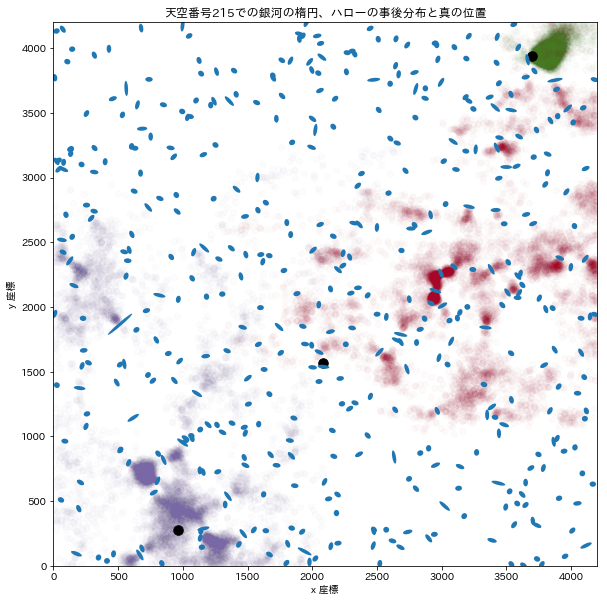

In [67]:
fig = draw_sky(data)

colors = ['#467821',"#A60628", "#7A68A6"]

for i in range(traces.shape[1]):
    plt.scatter(traces[:, i, 0], traces[:, i, 1], c=colors[i], alpha=0.02)
    
for i in range(traces.shape[1]):
    plt.scatter(halo_data[n_sky - 1][3 + 2  * i],
               halo_data[n_sky - 1][4 + 2 * i], c="k", s=90, label="ハローの真の位置")
    
plt.xlim(0, 4200)
plt.ylim(0, 4200)
plt.xlabel("x 座標")
plt.ylabel("y 座標")
plt.title("天空番号%dでの銀河の楕円、ハローの事後分布と真の位置" % n_sky)

In [68]:
_halo_data = halo_data[n_sky -1]
print(traces.shape)

mean_posterior = traces.mean(axis=0).reshape(1, 6)
print(mean_posterior)

nhalo_all = _halo_data[0].reshape(1, 1)
x_ref_all = _halo_data[1].reshape(1, 1)
y_ref_all = _halo_data[2].reshape(1, 1)
x_true_all = _halo_data[3].reshape(1, 1)
y_true_all = _halo_data[4].reshape(1, 1)
sky_prediction = mean_posterior

print("平均を使う: ")
main_score([1], x_true_all, y_true_all,x_ref_all, y_ref_all, sky_prediction)
print()

# 駄目なスコアの例として、ランダムな場所で計算する
random_guess = np.random.randint(0, 4200, size=(1, 2))
print("ランダムの位置: ",random_guess)
main_score([1], x_true_all, y_true_all,x_ref_all, y_ref_all, random_guess)


(10000, 3, 2)
[[3819.73445141 3964.54719768 3237.62989505 2263.8340605   897.14401933
   848.71932509]]
平均を使う: 
Your average distance in pixels you are away from the true halo is 125.33373823408533
Your average angular vector is 0.9999999999999999
Your score for the training data is 1.1253337382340853

ランダムの位置:  [[1967  332]]
Your average distance in pixels you are away from the true halo is 4002.9088566316373
Your average angular vector is 1.0
Your score for the training data is 5.002908856631637


5.002908856631637